# SME Tests

## Loading data

In [150]:
%matplotlib inline

from datetime import date, time, timedelta, datetime
from enum import Enum

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from autotraderpy.historical import HistoricalRetriever

In [77]:
retriever = HistoricalRetriever()
data = retriever.retrieve_bar_data(
    symbol="SPY",
    bar_size=timedelta(minutes=1),
    start_date=date(2020, 3, 12),
    end_date=date(2020, 4, 8),
    cache_only=True,
)

In [78]:
all_dates = np.unique(data.index.date)
training_dates = all_dates[:int(len(all_dates) * .75)]

training_dates

array([datetime.date(2020, 3, 12), datetime.date(2020, 3, 13),
       datetime.date(2020, 3, 16), datetime.date(2020, 3, 17),
       datetime.date(2020, 3, 18), datetime.date(2020, 3, 19),
       datetime.date(2020, 3, 20), datetime.date(2020, 3, 23),
       datetime.date(2020, 3, 24), datetime.date(2020, 3, 25),
       datetime.date(2020, 3, 26), datetime.date(2020, 3, 27),
       datetime.date(2020, 3, 30), datetime.date(2020, 3, 31),
       datetime.date(2020, 4, 1)], dtype=object)

In [79]:
mask = (data.index.date <= training_dates[-1])

training_data = data[mask]
training_data

,open,high,low,close,volume,adj close
datetime,,,,,,
2020-03-12 09:30:00,256.260010,256.299988,256.260010,256.260010,12561028,256.260010
2020-03-12 09:31:00,256.359985,256.359985,256.359985,256.359985,1531354,256.359985
2020-03-12 09:32:00,256.369995,256.890015,256.000000,256.079987,1241507,256.079987
2020-03-12 09:33:00,256.079987,256.239990,255.320007,255.710007,1093705,255.710007
2020-03-12 09:34:00,255.660004,255.789993,255.050003,255.289993,1509536,255.289993
...,...,...,...,...,...,...
2020-04-01 15:55:00,246.520004,247.199097,246.490005,247.199097,1517273,247.199097
2020-04-01 15:56:00,247.199997,247.240005,246.190002,246.494995,1361320,246.494995
2020-04-01 15:57:00,246.500000,246.539993,245.750000,245.985001,1179378,245.985001


## Graphing the SME for single day

### Calculating SME

In [130]:
day_data = training_data[training_data.index.date == date(2020, 3, 12)]
day_data["sme_close"] = day_data["close"].rolling(window=60).mean()
day_data["sme_upper"] = day_data["sme_close"] * 1.005
day_data["sme_lower"] = day_data["sme_close"] * 0.995

/home/petioptrv/miniconda3/envs/automated-trading/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/petioptrv/miniconda3/envs/automated-trading/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/petioptrv/miniconda3/envs/automated-trading/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A val

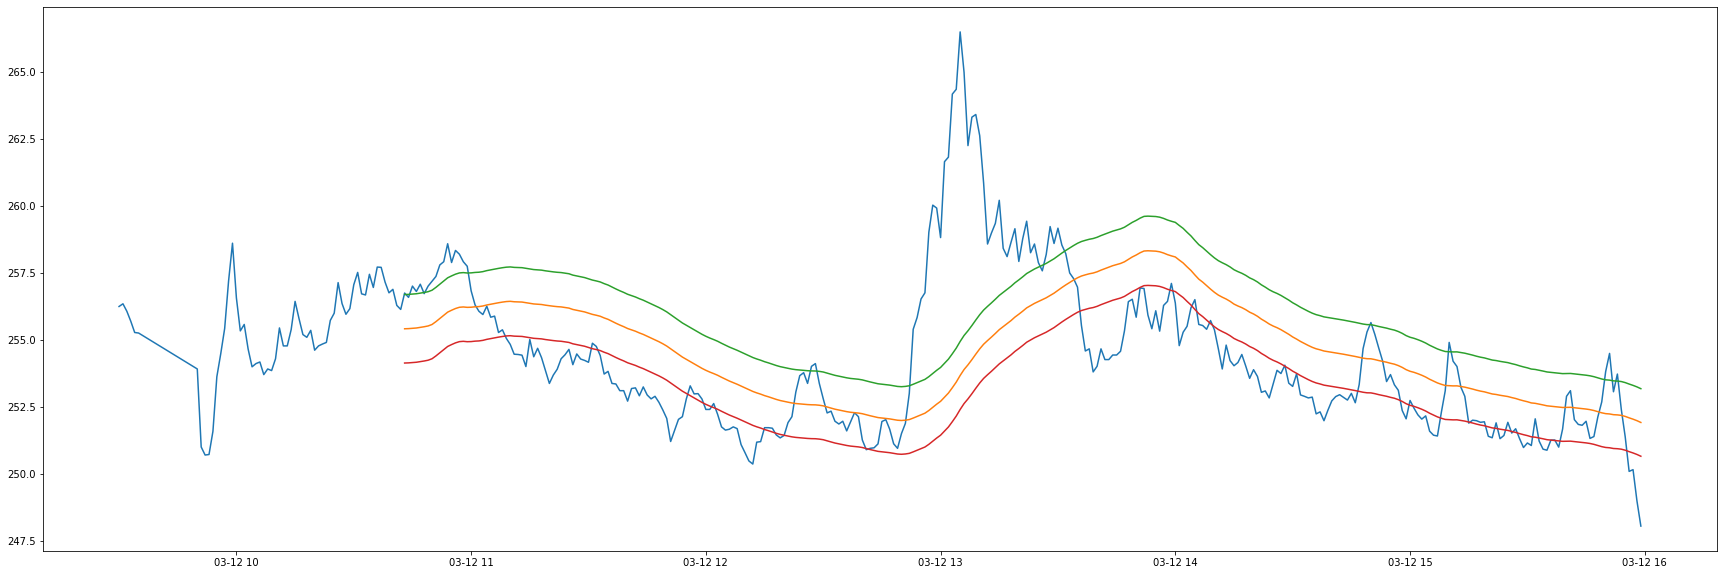

In [131]:
plt.figure(figsize=(30, 10))
plt.plot(day_data[["close", "sme_close", "sme_upper", "sme_lower"]])

## Trader

In [ ]:
class Actions(Enum):
    BUY = 0
    SELL = 1
    CLOSE = 2
    

class State(Enum):
    ABOVE_UPPER = 0
    ABOVE_MID = 1
    BELOW_MID = 2
    BELOW_LOWER = 3


class SMETrader:
    def __init__(
        self,
        window: int,
        offset: float,
        starting_funds: float,
        exit_start: time,
        full_exit: time,
    ):
        self._sme_buffer = np.full((window,), np.nan)
        self._offset = offset
        self._bar_count = 0
        self._funds = starting_funds
        self._position = 0
        self._exit_start = exit_start
        self._full_exit = full_exit
        self._state = None
    
    def step(self, bar: pd.Series):
        bar_index = self._bar_count % len(self._sme_buffer)
        self._sme_buffer[bar_index] = candle["close"]
        self._bar_count += 1
        
        if not np.any(np.isnan(self._sme_buffer)):
            self._execute_logic(bar=bar)
        
    def _execute_logic(self, bar: pd.Series):
        if self._state is not None:
            action = self._get_action(bar=bar)
        
        self._update_state(bar=bar)
        
    def _get_action(self, bar: pd.Series):
        upper, sme, lower = self._compute_sme()
        
        
    def _compute_sme(self, bar: pd.Series):
        sme = self._sme_buffer.mean()
        upper = sme * (1 + self._offset)
        lower = sme * (1 - self._offset)
        
        return upper, sme, lower
    
    def _update_state(self, bar: pd.Series):
        upper, sme, lower = self._compute_sme()
        
        if bar["close"] >= upper:
            self._state = State.ABOVE_UPPER
        elif bar["close"] >= sme:
            self._state = State.ABOVE_MID
        elif bar["close"] >= lower:
            self._state = State.BELOW_MID
        else:
            self._state = State.BELOW_LOWER